<a href="https://colab.research.google.com/github/alexk2206/Data_Driven_Fantasy_Football/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import ast

In [2]:
# MIP drafts für ein Jahr
year = 2020
MIP_dfs = []
for run in range(1, 6):
    url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/simulations/MIP/simulation_results_MIP_ALL_{year}_run{run}.json"
    df = pd.read_json(url)
    df["Run"] = run
    MIP_dfs.append(df)

MIP_sim = pd.concat(MIP_dfs, ignore_index=True)

In [3]:
# ADP drafts für ein Jahr
if year == 2024:
    ADP_dfs = []
    for run in range(1, 2):
        url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/refs/heads/main/simulations/ADP/simulation_results_ADP_ALL_{year}_run{run}.json"
        df = pd.read_json(url)
        df["Run"] = run
        ADP_dfs.append(df)

    ADP_sim = (
        pd.concat(ADP_dfs, ignore_index=True)
    )
    print(len(ADP_sim))
    print(ADP_sim.head())
else:
    ADP_dfs = []
    for run in range(1, 11):
        url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/refs/heads/main/simulations/ADP/simulation_results_ADP_{run}_{year}.json"
        df = pd.read_json(url)
        df["Run"] = run
        ADP_dfs.append(df)

    ADP_sim = (
        pd.concat(ADP_dfs, ignore_index=True)
    )
    print(len(ADP_sim))
    print(ADP_sim.head())

500
   Simulation   Winner                                             Roster  \
0           1   Team 6  [Clyde Edwards-Helaire / 9.22, Derrick Henry /...   
1           2  Team 10  [Joe Mixon / 13.10, Travis Kelce / 18.30, Melv...   
2           3  Team 11  [Tyreek Hill / 14.20, Derrick Henry / 16.10, M...   
3           4   Team 1  [Christian McCaffrey / 1.92, Mike Evans / 27.9...   
4           5  Team 10  [DeAndre Hopkins / 13.40, Derrick Henry / 16.1...   

   Points Reg Season  Points Full Season  Run  
0            1494.28             1722.32    1  
1            1334.88             1554.02    1  
2            1455.72             1660.64    1  
3            1310.90             1582.94    1  
4            1503.04             1767.76    1  


In [4]:
#ADP und MIP drafts für mehrere Jahre

adp_all_years = []

for year in range(2020, 2025):
    adp_dfs = []
    if year == 2024:
        for run in range(1, 2):
            url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/refs/heads/main/simulations/ADP/simulation_results_ADP_ALL_{year}_run{run}.json"
            df = pd.read_json(url)
            df["Run"] = run
            df["Season"] = year
            adp_dfs.append(df)
    else:
        for run in range(1, 11):
            url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/refs/heads/main/simulations/ADP/simulation_results_ADP_{run}_{year}.json"
            df = pd.read_json(url)
            df["Run"] = run
            df["Season"] = year
            adp_dfs.append(df)

    year_df = pd.concat(adp_dfs, ignore_index=True)
    adp_all_years.append(year_df)

ADP_sim_all = pd.concat(adp_all_years, ignore_index=True)

mip_all_years = []

for year in range(2020, 2025):
    mip_dfs = []
    for run in range(1, 6):
        url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/simulations/MIP/simulation_results_MIP_ALL_{year}_run{run}.json"
        df = pd.read_json(url)
        df["Run"] = run
        df["Season"] = year
        mip_dfs.append(df)

    year_df = pd.concat(mip_dfs, ignore_index=True)
    mip_all_years.append(year_df)

MIP_sim_all = pd.concat(mip_all_years, ignore_index=True)

print(len(ADP_sim_all))
print(len(MIP_sim_all))
# sample where DM-Team-Win == True


2500
2500


# Vergleich Winrates pro Startplatz

    Draftslot  ADP_Winrate  MIP_Winrate
0           1        0.060     0.000000
1           2        0.046     0.000000
2           3        0.142     0.000000
3           4        0.116     0.035088
4           5        0.072     0.000000
5           6        0.060     0.000000
6           7        0.130     0.026316
7           8        0.104     0.000000
8           9        0.064     0.000000
9          10        0.096     0.000000
10         11        0.066     0.000000
11         12        0.044     0.000000


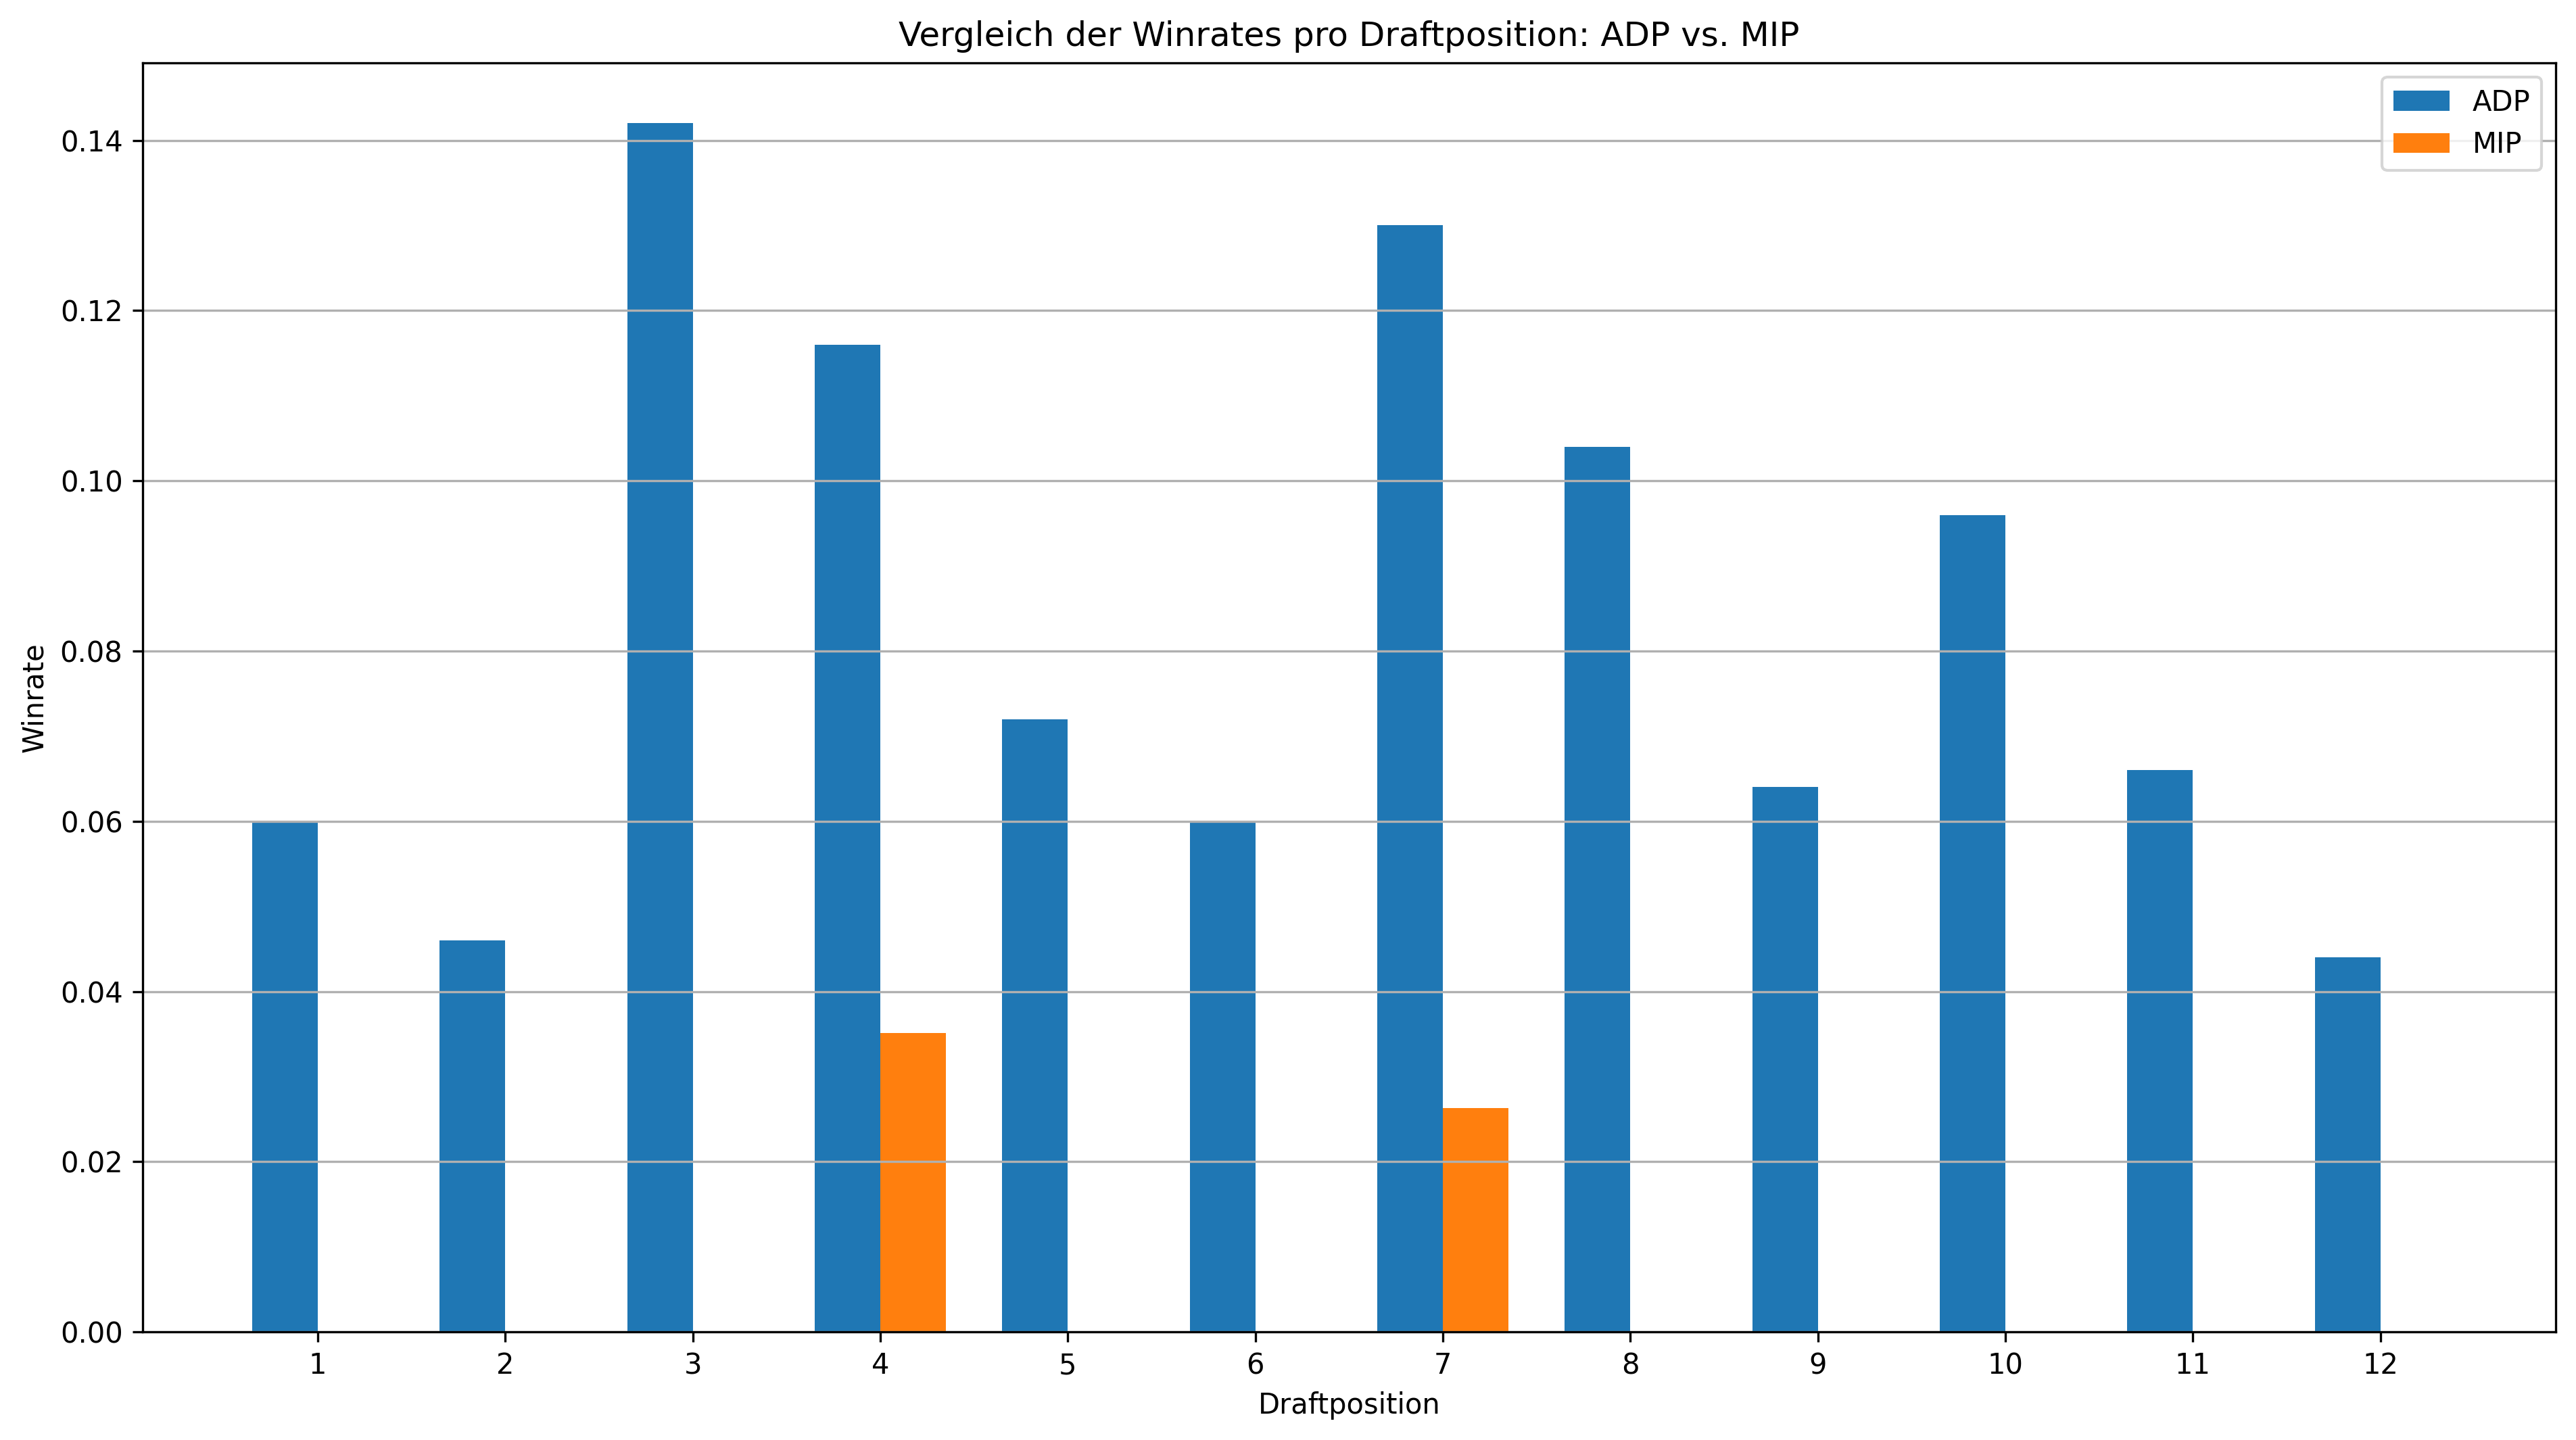

In [6]:
ADP_sim["Draftslot"] = ADP_sim["Winner"].str.extract(r"(\d+)").astype(int)

ADP_winrate_df = (
    ADP_sim.groupby("Draftslot")
    .size()
    .rename("Wins")
    .reset_index()
)

total_sims = len(ADP_sim)
ADP_winrate_df["Simulations"] = total_sims
ADP_winrate_df["Winrate"] = ADP_winrate_df["Wins"] / total_sims

# print(ADP_winrate_df)

# Draftslot aus DM-Team extrahieren
MIP_sim["Draftslot"] = MIP_sim["DM-Team"].str.extract(r"(\d+)").astype(int)

# Filter: Nur gewonnene DM-Simulationen
winners_only = MIP_sim[MIP_sim["DM-Team-Win"] == True].copy()

# Gruppierung: Siege pro Draftslot
win_counts = winners_only["Draftslot"].value_counts().sort_index()

# Alle Simulationen pro Slot (auch verlorene) zählen
total_counts = MIP_sim["Draftslot"].value_counts().sort_index()

# DataFrame erstellen
MIP_winrate_df = (
    pd.DataFrame({
        "Wins": win_counts,
        "Simulations": total_counts
    })
    .fillna(0)
    .astype(int)
    .assign(Winrate=lambda df: df["Wins"] / df["Simulations"])
    .reset_index()
    .rename(columns={"index": "Draftslot"})
    .sort_values("Draftslot")
)

# print(MIP_winrate_df)


# Plot

# Umbenennen der Winrate-Spalten zur Unterscheidung
ADP_df = ADP_winrate_df[["Draftslot", "Winrate"]].rename(columns={"Winrate": "ADP_Winrate"})
MIP_df = MIP_winrate_df[["Draftslot", "Winrate"]].rename(columns={"Winrate": "MIP_Winrate"})

# Zusammenführen
compare_df = pd.merge(ADP_df, MIP_df, on="Draftslot").sort_values("Draftslot")
print(compare_df)

# Balkendiagramm
x = compare_df["Draftslot"]
width = 0.35

fig, ax = plt.subplots(figsize=(3840 / 300, 2160 / 300), dpi=300)
ax.bar(x - width/2, compare_df["ADP_Winrate"], width, label="ADP")
ax.bar(x + width/2, compare_df["MIP_Winrate"], width, label="MIP")

# Layout
ax.set_xlabel("Draftposition")
ax.set_ylabel("Winrate")
ax.set_title("Vergleich der Winrates pro Draftposition: ADP vs. MIP")
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

fig.savefig(f"winrate_comparison_{year}.png")

# Punkteverteilung DM-Team pro Saison inklusive overall Winrate

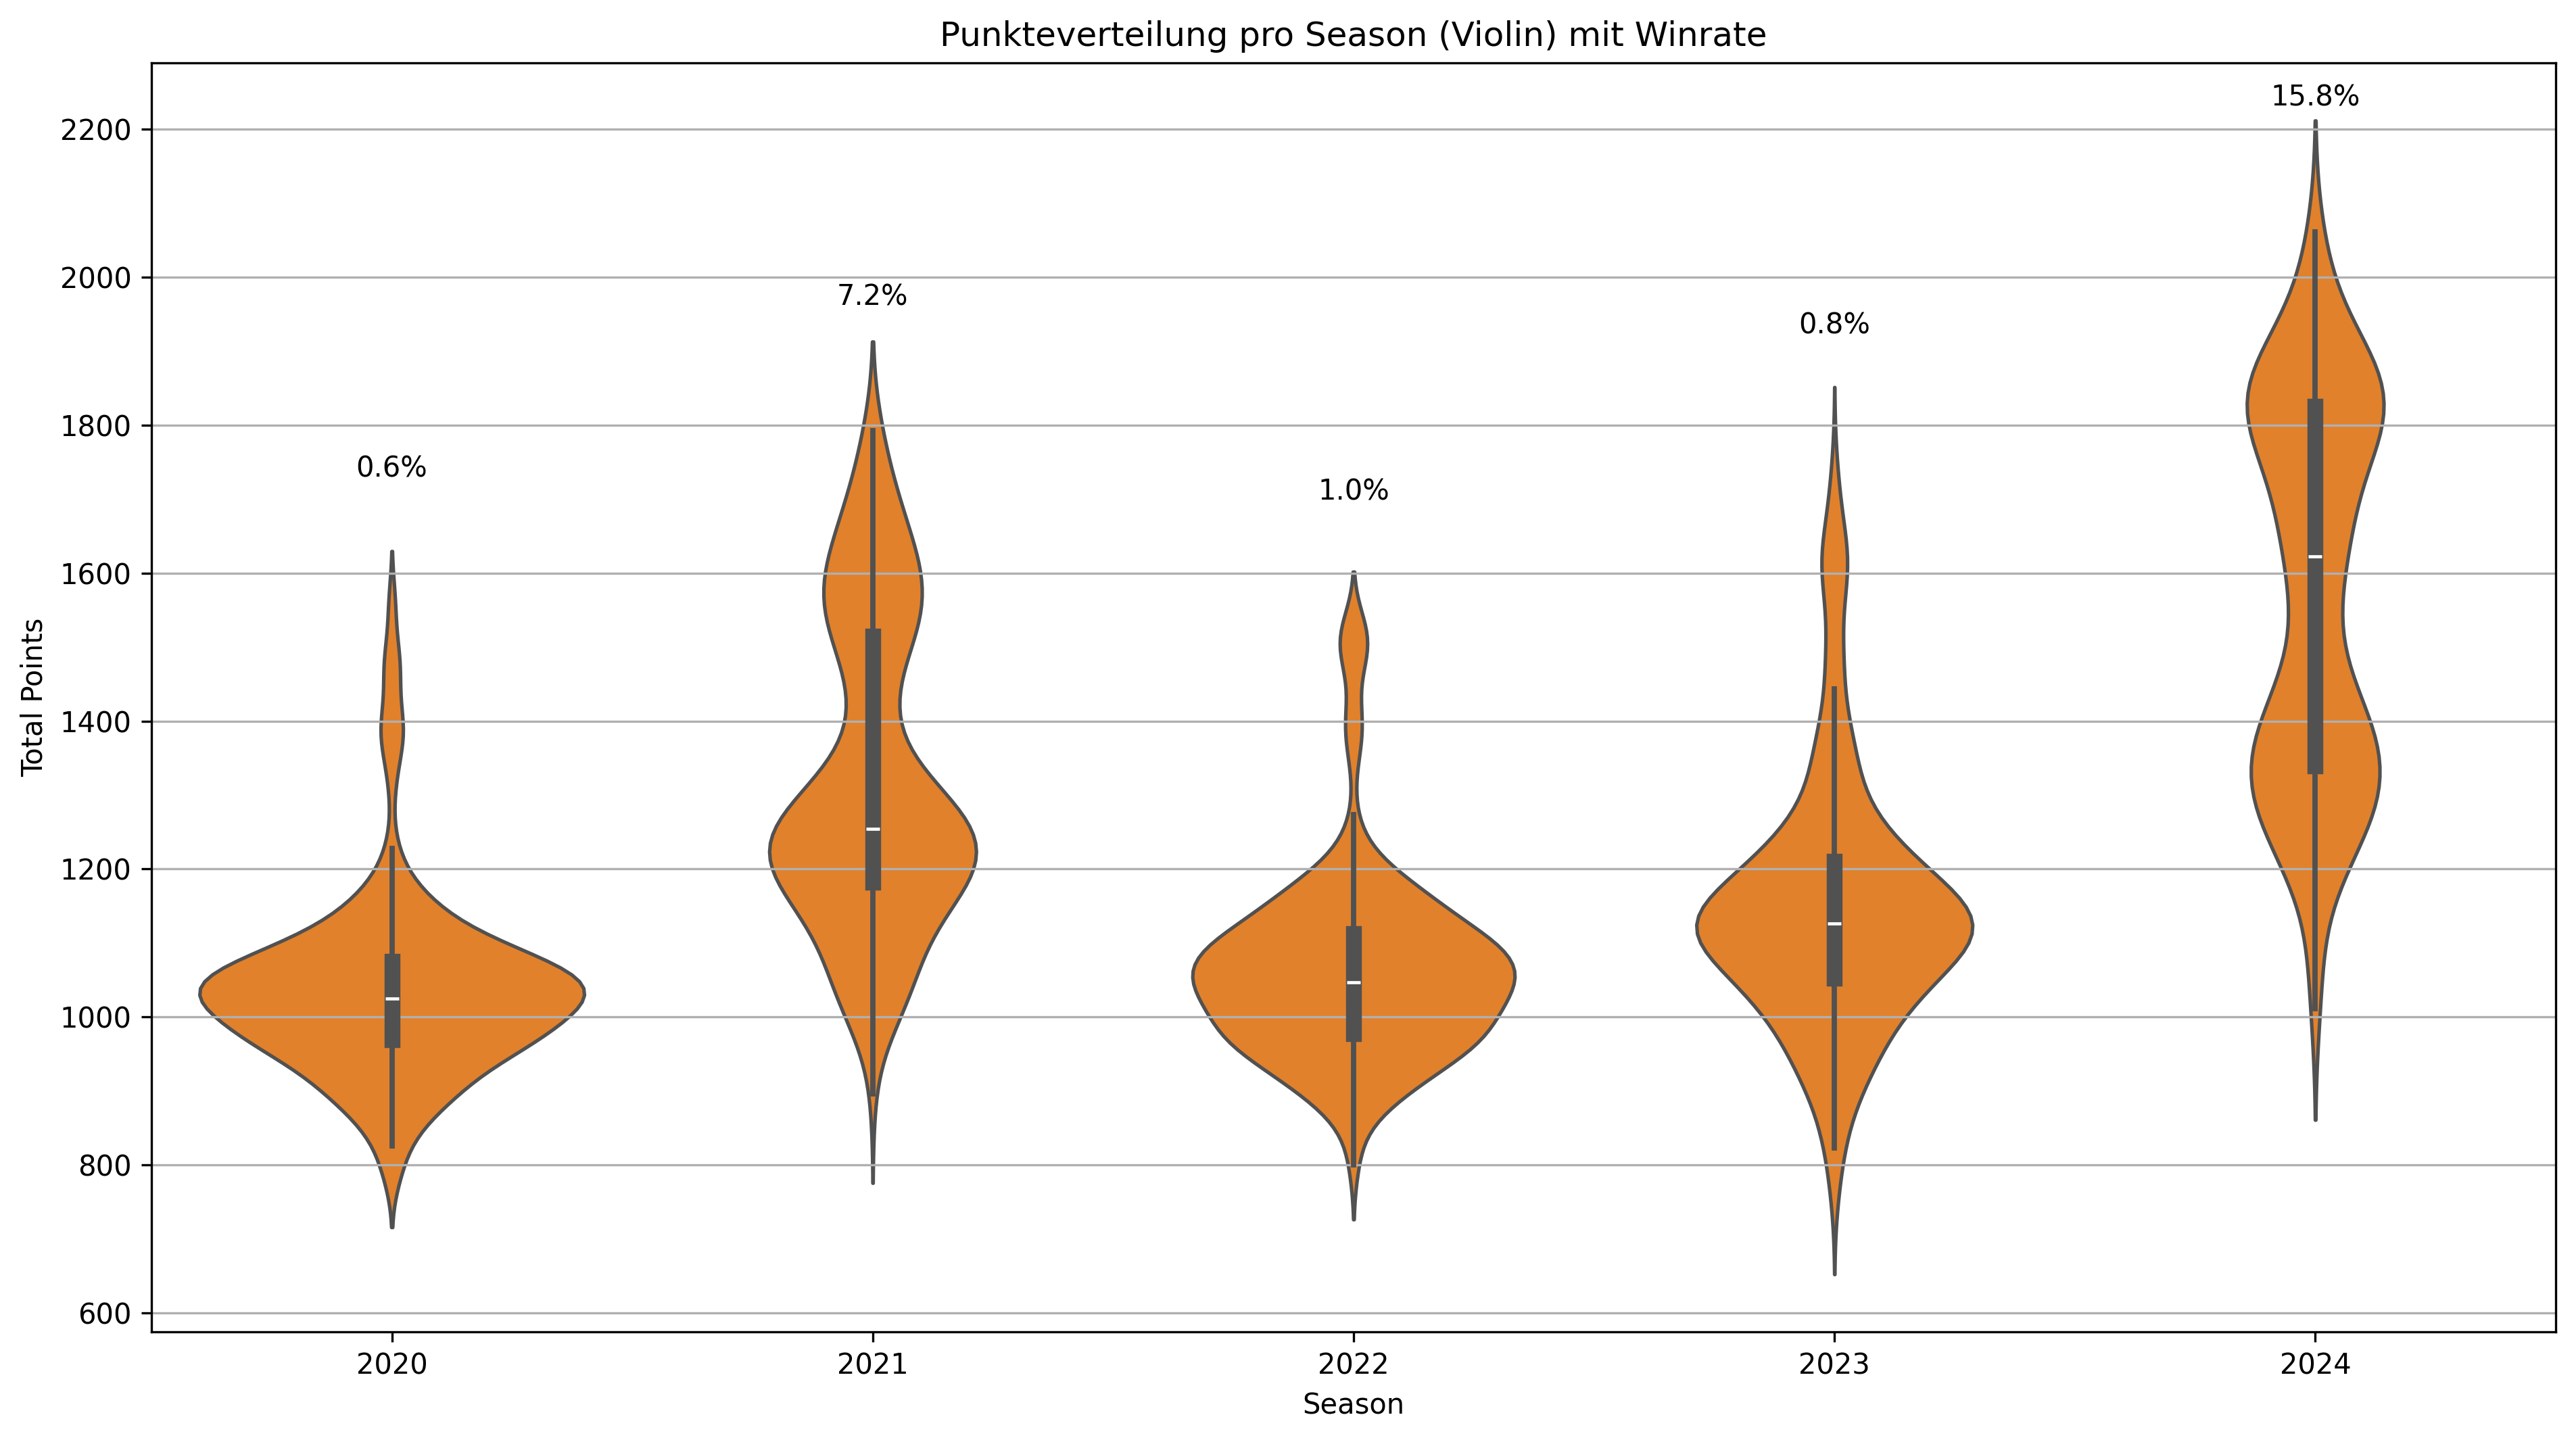

In [7]:
# Punkte berechnen
MIP_sim_all["Total_Points"] = (
    MIP_sim_all["DM-Points-Regular-Season"] + MIP_sim_all["DM-Points-Playoffs"]
)

# Winrate je Season berechnen
winrate_per_season = (
    MIP_sim_all.groupby("Season")["DM-Team-Win"]
    .agg(Wins="sum", Simulations="count")
    .assign(Winrate=lambda df: df["Wins"] / df["Simulations"])
)

# plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(3840 / 300, 2160 / 300), dpi=300)
sns.violinplot(data=MIP_sim_all, x="Season", y="Total_Points", inner="box", color = '#ff7f0e')

# Winrate drüber schreiben
for season, row in winrate_per_season.iterrows():
    xpos = sorted(MIP_sim_all["Season"].unique()).index(season)
    ymax = MIP_sim_all[MIP_sim_all["Season"] == season]["Total_Points"].max()
    plt.text(xpos, ymax + 170, f'{row["Winrate"]:.1%}', ha='center')

plt.title("Punkteverteilung pro Season (Violin) mit Winrate")
plt.ylabel("Total Points")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

fig.savefig("violinplot_total_points_winrate_orange_4k.png")

# Häufigste Spieler aus DM-Teams pro Runde bis ADP 60

In [15]:
year = 2020

real_data_FP_url = f'https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/Weekly_Data/FantasyPros_Fantasy_Football_Points_PPR_{year}.csv'
real_data_FP = (
    pd.read_csv(real_data_FP_url)
      .rename(columns={'player_display_name': 'Player', 'TTL': 'TTL Points'})
      .loc[:, ['Player', 'TTL Points']]
)

adp_url = f'https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/pre_season_data/adp_projections_{year}.csv'
player_adp = (
    pd.read_csv(adp_url)
      .rename(columns={'player': 'Player', 'points': 'TTL Projection'})
      .loc[:, ['Player', 'TTL Projection']]
      .drop_duplicates(subset='Player', keep='first')
      .dropna(subset=['Player'])
      .reset_index(drop=True)
)

In [16]:
num_teams = 12
adp_cutoff = num_teams * 5

def analyze_all_picks(MIP_sim: pd.DataFrame) -> pd.DataFrame:
    player_picks = []

    for picks_raw in MIP_sim["DM-Picks"]:
        picks = ast.literal_eval(picks_raw) if isinstance(picks_raw, str) else picks_raw
        for pick in picks:
            match = re.match(r"^(.*) \(Pick (\d+)\)$", pick)
            if match:
                player = match.group(1).strip()
                pick_number = int(match.group(2))
                player_picks.append((player, pick_number))

    df_picks = pd.DataFrame(player_picks, columns=["Player", "Pick"])

    pick_summary = (
        df_picks
        .groupby("Player")
        .agg(
            Times_Drafted=("Pick", "count"),
            ADP=("Pick", "mean")
        )
        .assign(Share=lambda df: df["Times_Drafted"] / len(MIP_sim))
        .sort_values(by="ADP", ascending=True)
        .reset_index()
        .merge(real_data_FP, on="Player", how="left")
        .merge(player_adp, on="Player", how="left")
        .loc[:, ["Player", "Times_Drafted", "Share", "ADP", "TTL Points", "TTL Projection"]]
        )

    return pick_summary
df_pick_stats = analyze_all_picks(MIP_sim)
df_pick_stats = df_pick_stats[df_pick_stats['ADP'] <= adp_cutoff].copy()
display(df_pick_stats)

,Player,Times_Drafted,Share,ADP,TTL Points,TTL Projection
0,Dalvin Cook,218,0.436,3.174312,337.8,304.0
1,Joe Mixon,212,0.424,7.877358,99.6,261.0
2,Derrick Henry,171,0.342,15.456140,333.1,263.0
3,Aaron Jones,181,0.362,18.016575,258.9,264.0
4,James Conner,79,0.158,21.632911,164.6,231.0
5,Odell Beckham,138,0.276,22.710145,86.8,244.0
6,Miles Sanders,152,0.304,27.072368,170.4,271.0
7,Mike Evans,79,0.158,29.670886,248.6,241.0
8,David Johnson,233,0.466,33.124464,179.5,230.0
9,LeVeon Bell,92,0.184,37.369565,74.6,233.0
